In [7]:
# Check system install
import torch
print(torch.__version__)
print(torch.cuda.is_available())  # Should return True if GPU is detected

# General Imports
import numpy as np
import pandas as pd
import random
from tqdm import tqdm 
from torch.optim import Adam
import monai
import matplotlib.pyplot as plt

from concurrent.futures import ThreadPoolExecutor



# Class Imports
# Reload modules so classes are reloaded every time
import importlib
import image_mask_dataset
import model_evaluator

importlib.reload(image_mask_dataset)
importlib.reload(model_evaluator)

from image_mask_dataset import ImageMaskDataset
from model_evaluator import ModelEvaluator




# SAM
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
from transformers import SamModel



2.6.0+cu126
True


## Gather data for each split

In [8]:
# Create dataset objects for each split
dataset_path = "Datasets/Dental project.v19i.coco-1"

test_dataset = ImageMaskDataset(dataset_path, "test")
train_dataset = ImageMaskDataset(dataset_path, "train")
valid_dataset = ImageMaskDataset(dataset_path, "valid")

# Test using a random image
# test_dataset.show_image_mask(random.randint(0,len(test_dataset)-1))
# train_dataset.show_image_mask(random.randint(0,len(train_dataset)-1))
# valid_dataset.show_image_mask(random.randint(0,len(valid_dataset)-1))



100%|██████████| 156/156 [00:00<00:00, 10204.48it/s]


# Evaluate SAM model 
### Get image:

In [ ]:
# Select random image
image_idx = random.randint(0, len(test_dataset)-1)

# Load an image
image_tensor= test_dataset[image_idx][0]

# Ensure the image tensor is in the correct shape for SAM
image_np = image_tensor.permute(1, 2, 0).cpu().numpy()  # Convert tensor (C, H, W) to (H, W, C)

### SAM - Base model predictions (no grid):

In [10]:
# Load the SAM model
sam_checkpoint = "Models/sam_vit_l_0b3195.pth" 
sam_model = sam_model_registry["vit_l"](checkpoint=sam_checkpoint)
sam_model = sam_model.to("cuda")

# Initialize Automatic Mask Generator and generate mask
mask_generator = SamAutomaticMaskGenerator(sam_model)
masks = mask_generator.generate(image_np)


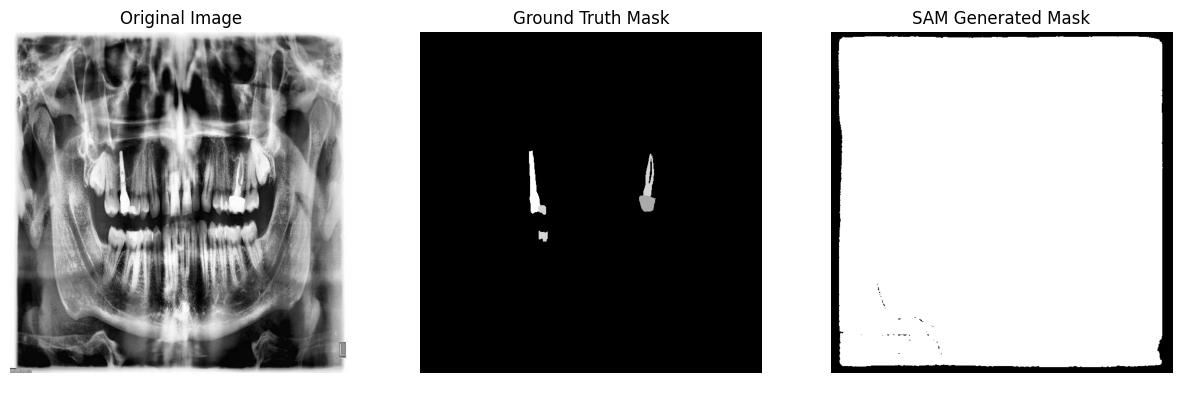

In [11]:
# Visualise Output
test_dataset.compare_image_masks(image_idx, masks)

### SAM - Base model predictions (grid of points):

In [12]:
# Create grid of points on image
height, width, _ = image_np.shape
num_points = 5  # 5*5 points

# Generate grid points
grid_points = []
for y in range(0, height, height // num_points):
    for x in range(0, width, width // num_points):
        grid_points.append([y, x])  # Each point is (x, y)

grid_points = np.array(grid_points)



# Initialize the SAM predictor
sam_predictor = SamPredictor(sam_model)

# Set the image once for the SAM predictor
sam_predictor.set_image(image_np)



# Function to generate mask for each point
def generate_mask_for_point(point):
    return sam_predictor.predict(point_coords=point[None, :], point_labels=np.array([1]))

# Use ThreadPoolExecutor to parallelize mask generation
with ThreadPoolExecutor() as executor:
    masks = list(executor.map(generate_mask_for_point, grid_points))


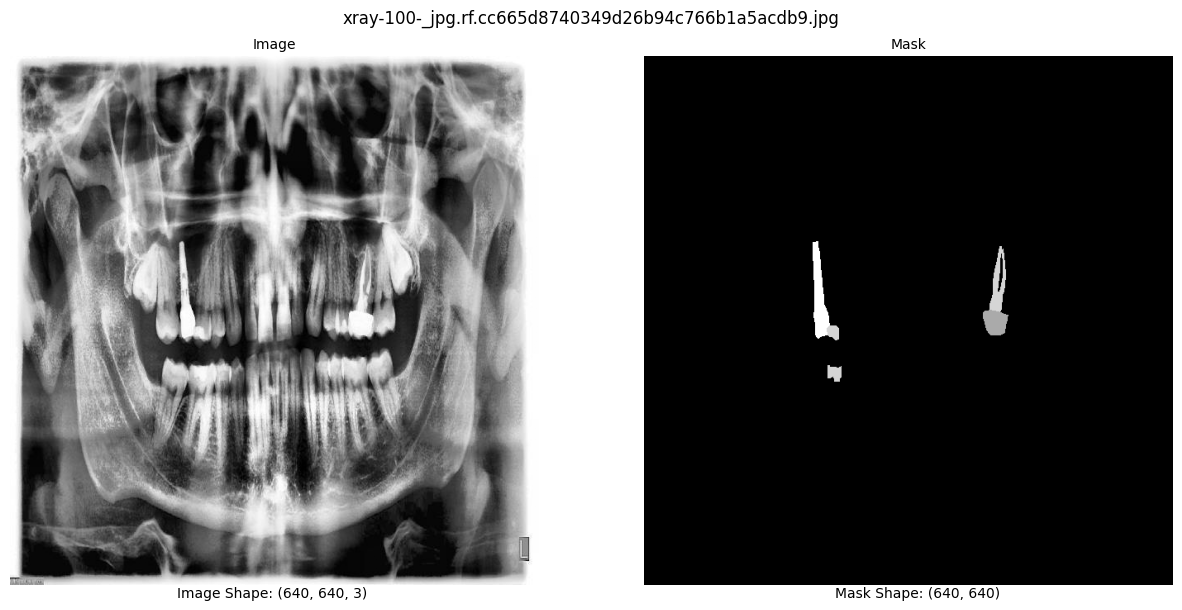

In [14]:
# Visualise Output
test_dataset.show_image_mask(image_idx)



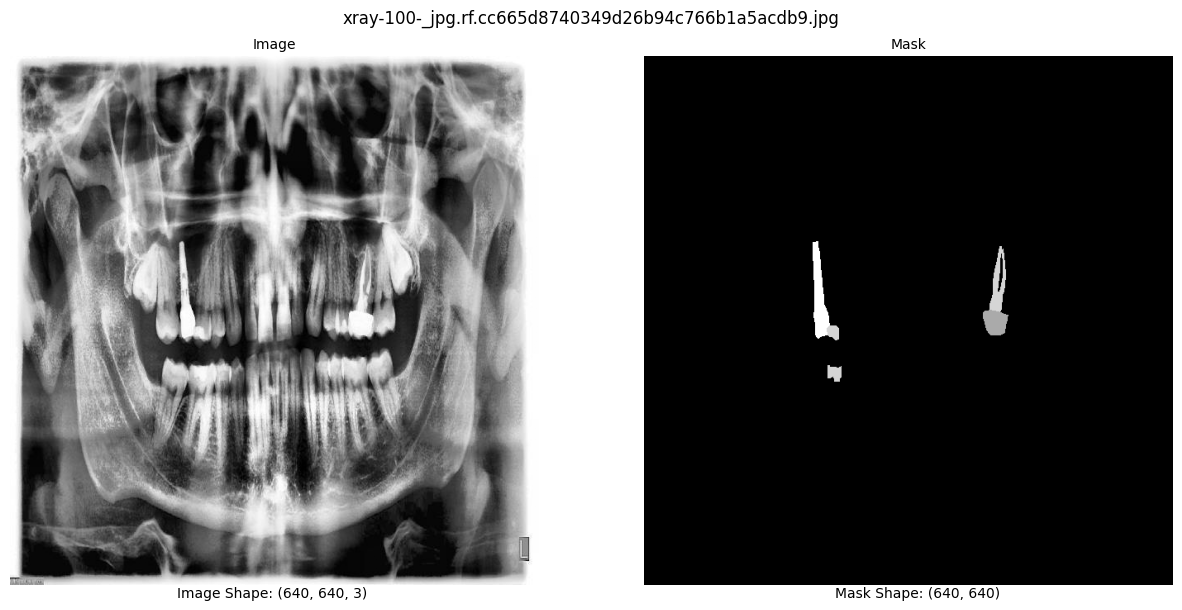

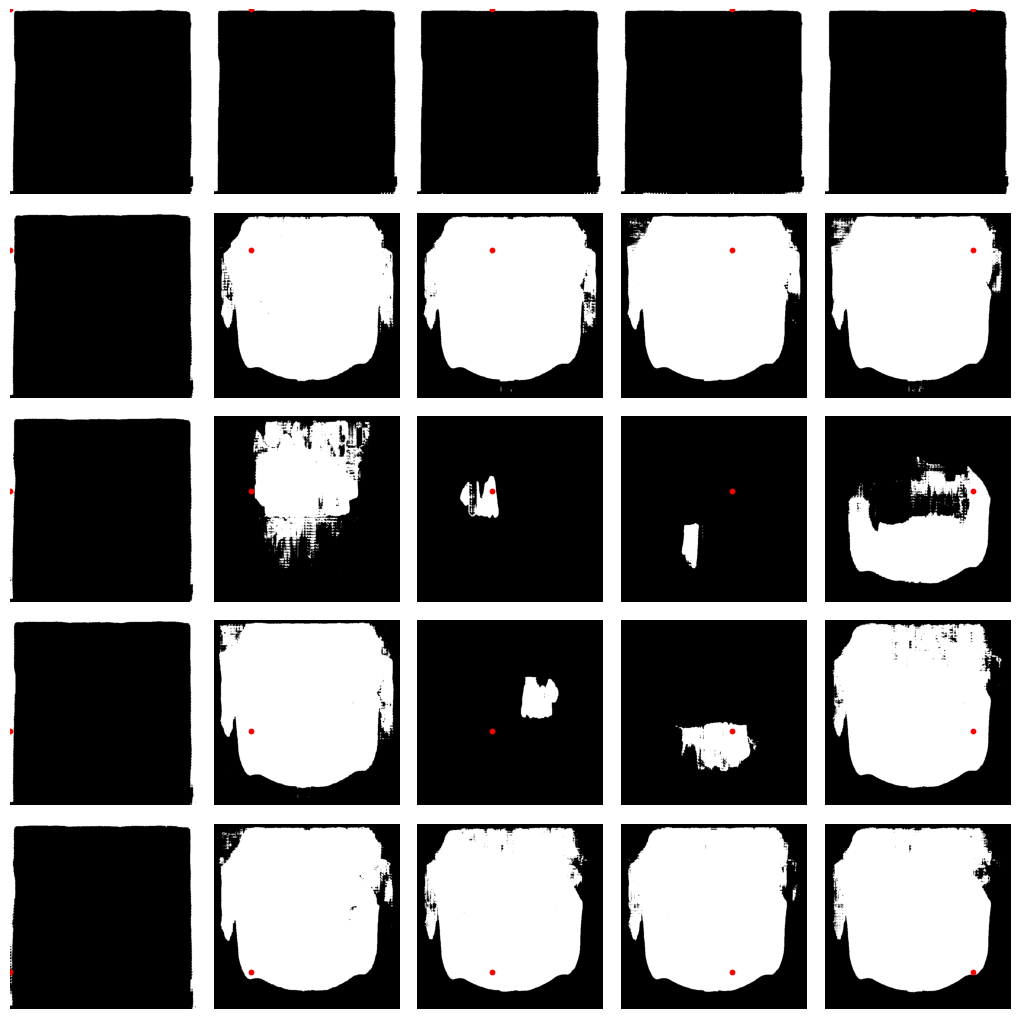

In [ ]:

test_dataset.show_image_mask(image_idx)



fig, axes = plt.subplots(num_points, num_points, figsize=(10, 10))  # Adjust figure size
axes = axes.flatten()  # Flatten in case of 2D grid

for i, (mask, point) in enumerate(zip(masks, grid_points)):
    mask_array = mask[0]

    # Ensure mask is 2D
    if mask_array.ndim > 2:
        mask_array = mask_array[0, :, :]

    # Display the mask
    axes[i].imshow(mask_array, cmap='gray')
    axes[i].axis("off")  # Remove axis

    # Plot the grid point as a red dot
    y, x = point  # Extract (y, x) coordinates
    axes[i].scatter(x, y, color='red', s=10)  # Red dot at grid point


# Remove gaps
plt.subplots_adjust(left=0, right=1, top=1, bottom=0, wspace=0.1, hspace=0.1)
plt.show()


## Model Evaluation

(640, 640, 3)   (640, 640, 1)


c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(
c:\Users\osmit\anaconda3\envs\pytorch-env\lib\site-packages\sklearn\metrics\_classification.py:407: UserWarning: A single label was found in '

{0: {'IoU': 0.9599121093749993, 'Precision': 1.0, 'Recall': 0.9599121093749993, 'F1 Score': 0.9782400579864223, 'Dice Score': 626.0736371113089, 'MCC': 0.0}}


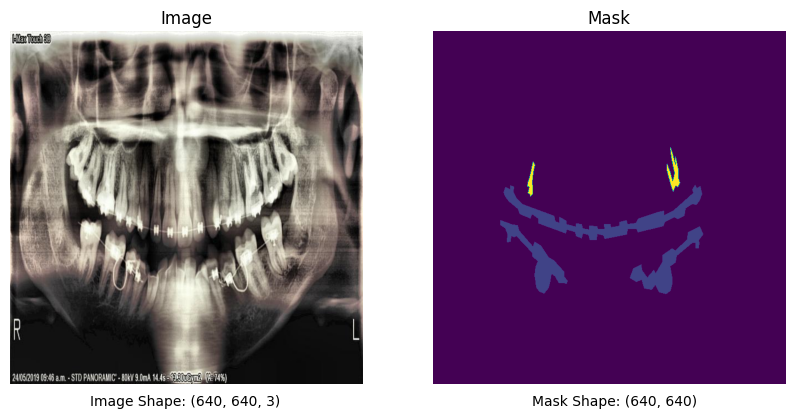

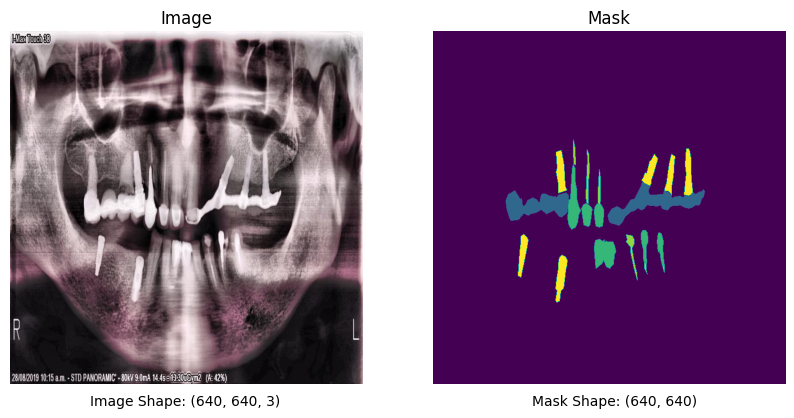

In [ ]:

# Example Usage:
# Load images (replace with your actual method)
image_tensor1, GT_mask1 = test_dataset[0]
image_tensor2, GT_mask2 = test_dataset[1]

# Convert image tensors (C, H, W) to (H, W, C) numpy arrays
image_np1 = image_tensor1.permute(1, 2, 0).numpy()
image_np2 = image_tensor2.permute(1, 2, 0).numpy()

GT_mask1 = GT_mask1.permute(1, 2, 0).numpy()
GT_mask2 = GT_mask2.permute(1, 2, 0).numpy()

# Now, pass them to the evaluator
masks = [image_np1, image_np2]  # Predicted masks (replace with your actual prediction)
gt_masks = [GT_mask1, GT_mask2]  # Ground truth masks

print(image_np1.shape, " " , GT_mask1.shape)

# Assuming model is initialized and passed to ModelEvaluator:
print(ModelEvaluator.evaluate_metrics(GT_mask1, GT_mask2))
test_dataset.show_image_mask(0)
test_dataset.show_image_mask(1)
